In [1]:
import torch
from torch import nn

# Model definition:

In [2]:
import torch


def parameterized_softmax(X, p=1):
    """
    Computes the parameterized softmax of an 2d array along the first axis.
    """
    return torch.exp(-p * X) / torch.sum(torch.exp(-p * X), dim=1).unsqueeze(1)


def lp_distance(X, Y, p=1):
    """
    Computes row wise minkowski distances between matrices X and Y
    """
    return torch.sum(torch.abs(X-Y)**p, dim=1)**(1/p)

In [3]:
class DeepKMeansWithLM(nn.Module):
    """
    This model implements the deep kmeans clustering as described in https://arxiv.org/abs/1806.10069.
    In order to adopt the algorithm for document clustering we use a lm to obtain low dimensional document representations
    Instead of the autoencoder reconstruction loss, we let the model continue the mask language task which is part of its pretraining
    """
    def __init__(self,
                 lm_model,
                 k,
                 n_features,
                 alpha=0.1,
                 lm_weight=0.1,
                 initial_centroids=None,
                 p=1,
                 device='cuda'):
        super(DeepKMeansWithLM, self).__init__()
        self.lm_model = lm_model
        self.k = k
        self.alpha = alpha
        self.p = p
        self.lm_weight = lm_weight
        self.device = device
        
        if initial_centroids is not None:
            assert initial_centroids.shape[0] == k, "Number of centroids must be equal to number of clusters"
            self.centroids = initial_centroidsi
        self.centroids = self._random_init_centroids(k, n_features)
        self.to(self.device)
        
        
    
        
    
    def forward(self, inputs):
        """
        Returns:
            (
                - idx of nearest centroid for each sample,
                - clustering loss average of summed distances of each input to sample to the centroid,
                - lm loss
                - combined and weighted loss
            )
        """
        
        # transfer input to device of the model instance
        inputs = inputs.to(self.device)
        
        # compute the lm loss w.r.t. to the inputs
        outputs = self.lm_model(labels=inputs['input_ids'], **inputs)
        lm_loss = outputs.loss
        
        # START: Clustering part
        
        # 0. obtain embeddings for each input
        input_embeddings = self.embed(inputs)
        
        # 1. compute distances of each input sample to each centroid
        # shape (n_samples, n_centroids)
        distances = torch.stack([lp_distance(embedding, self.centroids) for embedding in input_embeddings])
        
        # 2. get index nearest centroid for each sample
        nearest_centroids = distances.argmin(dim=1)
        
        # 3. compute softmax for each min_distance
        
        exponentials = torch.exp(-self.alpha * distances)
        
        softmaxes = []
        weighted_distances = []
        for index, nc in enumerate(nearest_centroids):
            min_distance = distances[index, nc]
            
            sm = torch.exp(-self.alpha * min_distance) / torch.sum(exponentials[index])
            softmaxes.append(sm)
            weighted_distances.append(distances[index] * sm)
            
        
        softmaxes = torch.tensor(softmaxes, dtype=torch.float32, device=self.device)
        weighted_distances = torch.stack(weighted_distances)
        
        clustering_loss = weighted_distances.sum(dim=1).mean()
        
        combined_loss = clustering_loss + self.lm_weight * lm_loss
        
        return nearest_centroids.cpu().detach(), clustering_loss, lm_loss, combined_loss
        
        
        
    
    def embed(self, inputs):
        """
        Returns the cls embeddings of the input sequences as provided by the base model of the lm_model
        """
        return self.lm_model.base_model(**inputs).last_hidden_state[:,0,:]
    
    def _random_init_centroids(self, k, n_dims):
        """
        Returns randomly uniform initalized centroids
        """
        return nn.Parameter(torch.rand((k, n_dims), device=self.device).to(self.device), requires_grad=True)

In [4]:
from transformers import PreTrainedTokenizer
from typing import *

def mask_tokens(inputs: torch.Tensor, tokenizer) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original.
    """

    if tokenizer.mask_token is None:
        raise ValueError(
            "This tokenizer does not have a mask token which is necessary for masked language modeling. Remove the --mlm flag if you want to use this tokenizer."
        )

    labels = inputs.clone()
    # We sample a few tokens in each sequence for masked-LM training (with probability args.mlm_probability defaults to 0.15 in Bert/RoBERTa)
    probability_matrix = torch.full(labels.shape, 0.15)
    special_tokens_mask = [
        tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
    ]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
    if tokenizer._pad_token is not None:
        padding_mask = labels.eq(tokenizer.pad_token_id)
        probability_matrix.masked_fill_(padding_mask, value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

In [5]:
#class DeepKMeansWithLM2(nn.Module):
#    """
#    This model implements the deep kmeans clustering as described in https://arxiv.org/abs/1806.10069.
#    In order to adopt the algorithm for document clustering we use a lm to obtain low dimensional document representations
#    Instead of the autoencoder reconstruction loss, we let the model continue the mask language task which is part of its pretraining
#    """
#    def __init__(self,
#                 lm_model,
#                 k,
#                 n_features,
#                 tokenizer,
#                 alpha=0.1,
#                 lm_weight=0.1,
#                 initial_centroids=None,
#                 p=1,
#                 device='cuda'):
#        super(DeepKMeansWithLM2, self).__init__()
#        self.lm_model = lm_model
#        self.k = k
#        self.alpha = alpha
#        self.p = p
#        self.lm_weight = lm_weight
#        self.tokenizer = tokenizer
#        self.device = device
#        
#        if initial_centroids is not None:
#            assert initial_centroids.shape[0] == k, "Number of centroids must be equal to number of clusters"
#            #self.centroids = nn.Parameter(initial_centroids.clone().to(torch.float64), requires_grad=True)
#            self.centroids = initial_centroids.clone().to('cuda').requires_grad_(True)
#        else:
#            self.centroids = self._random_init_centroids(k, n_features)
#            print("init centroids", self.centroids)
#        
#        self.to(self.device)
#    
#    def forward(self, inputs):
#        """
#        Returns:
#            (
#                - idx of nearest centroid for each sample,
#                - clustering loss average of summed distances of each input to sample to the centroid,
#                - lm loss
#                - combined and weighted loss
#            )
#        """
#        
#        # transfer input to device of the model instance
#        
#        
#        # compute the lm loss w.r.t. to the inputs
#        input_ids = inputs['input_ids'].clone()
#        input_ids, labels = mask_tokens(input_ids, self.tokenizer)
#        inputs['input_ids'] = input_ids
#
#        inputs = inputs.to(self.device)
#        labels = labels.to(self.device)
#        outputs = self.lm_model(labels=labels, **inputs)
#        lm_loss = outputs.loss
#        
#        
#        # 0. obtain embeddings for each input
#        input_embeddings = self.lm_model.base_model(**inputs).last_hidden_state[:,0,:]
#        input_embeddings = input_embeddings.to(torch.float64).requires_grad_(True)
#        
#        # START: Clustering part
#        # to compute the clustering loss we
#        # 1. compute the distance from each sample in batch to each centroid
#        distances = torch.stack([lp_distance(embedding.unsqueeze(0), self.centroids) for embedding in input_embeddings])
#        # nearest_centroids = torch.argmin(distances, dim=1).cpu().clone().detach()
#        nearest_centroids = torch.argmin(distances.cpu().clone().detach(), dim=1)
#        distances = torch.transpose(distances, 0, 1)    
#        
#        # => shape (n_centroids, n_samples)
#        # 2. compute the softmax for each centroid of each distance to each centroid per input sample
#        # find min distances for each centroid
#        #nearest_centroids = torch.min(distances, dim=0).indices.cpu().clone().detach()
#        
#        #min_distances = torch.min(distances).values
#        #exponentials = torch.exp(-self.alpha * (distances - min_distances.unsqueeze(1)))
#        exponentials = torch.exp(-self.alpha * (distances - torch.min(distances)))       
#        softmax = exponentials / torch.sum(exponentials, dim=1).unsqueeze(1)
#        
#        # 3. weight the distanace between each sample and each centroid
#        weighted_distances = distances * softmax
#        
#        # 4. sum over centroids to obtain loss
#        #clustering_loss = weighted_distances.mean(dim=1).sum().requires_grad_(True)
#        #clustering_loss = weighted_distances.min(dim=1).values.sum().requires_grad_(True)
#        clustering_loss = weighted_distances.sum()
#        
#        combined_loss =  clustering_loss + (self.lm_weight * lm_loss)
#        
#        #print("dists", distances)
#        #print(distances.requires_grad)
#        #print(distances.sum())
#        #print("inp_emb", input_embeddings)
#        #print("centroids", self.centroids)
#        #print(self.centroids.requires_grad)
#        #print("min_dists", min_distances)
#        #print("nerast_centroids", nearest_centroids)
#        #print("exponentials", exponentials)
#        #print("softmax", softmax)
#        #print("weighted_distances", weighted_distances)
#        #print(weighted_distances.requires_grad)
#        #print("clustering_loss", clustering_loss)
#        
#        return nearest_centroids, clustering_loss, lm_loss, combined_loss
#        
#        
#        
#    
#    def embed(self, inputs):
#        """
#        Returns the cls embeddings of the input sequences as provided by the base model of the lm_model
#        """
#        return self.lm_model.base_model(**inputs).last_hidden_state[:,0,:]
#    
#    def _random_init_centroids(self, k, n_dims):
#        """
#        Returns randomly uniform initalized centroids
#        """
#        #return torch.rand((k, n_dims), device=self.device), requires_grad=True)
#        return nn.Parameter(torch.Tensor(k, n_dims).uniform_(-1, 1).to(torch.float64), requires_grad=True)

In [6]:
class DeepKMeansWithLM2(nn.Module):
    """
    This model implements the deep kmeans clustering as described in https://arxiv.org/abs/1806.10069.
    In order to adopt the algorithm for document clustering we use a lm to obtain low dimensional document representations
    Instead of the autoencoder reconstruction loss, we let the model continue the mask language task which is part of its pretraining
    """
    def __init__(self,
                 lm_model,
                 k,
                 n_features,
                 tokenizer,
                 alpha=0.1,
                 lm_weight=0.1,
                 initial_centroids=None,
                 p=1,
                 device='cuda'):
        super(DeepKMeansWithLM2, self).__init__()
        self.lm_model = lm_model
        self.k = k
        self.alpha = alpha
        self.p = p
        self.lm_weight = lm_weight
        self.tokenizer = tokenizer
        self.device = device
        self.centroids = initial_centroids.clone().to('cuda').requires_grad_(True)

            
    def forward(self, inputs):
        """
        Returns:
            (
                - idx of nearest centroid for each sample,
                - clustering loss average of summed distances of each input to sample to the centroid,
                - lm loss
                - combined and weighted loss
            )
        """
        
        # transfer input to device of the model instance
        
        
        # compute the lm loss w.r.t. to the inputs
        input_ids = inputs['input_ids'].clone()
        input_ids, labels = mask_tokens(input_ids, self.tokenizer)
        inputs['input_ids'] = input_ids

        inputs = inputs.to(self.device)
        labels = labels.to(self.device)
        outputs = self.lm_model(labels=labels, **inputs)
        lm_loss = outputs.loss
        
        
        # 0. obtain embeddings for each input
        input_embeddings = self.lm_model.base_model(**inputs).last_hidden_state[:,0,:]
        input_embeddings = input_embeddings.to(torch.float64)


        # 1. compute distance to centroids
        distances = torch.stack([lp_distance(embedding.unsqueeze(0), self.centroids) for embedding in input_embeddings])
        nearest_centroids = torch.argmin(distances.cpu().clone().detach(), dim=1)
        distances = torch.transpose(distances, 0, 1)    

        # => shape (n_centroids, n_samples)
        # 2. compute the softmax for each centroid of each distance to each centroid per input sample
        # find min distances for each centroid

        min_distances = torch.min(distances, dim=1).values
        exponentials = torch.exp(-1 * (distances - min_distances.unsqueeze(1)))
        softmax = exponentials / torch.sum(exponentials, dim=1).unsqueeze(1)

        # 3. weight the distanace between each sample and each centroid
        weighted_distances = distances * softmax


        # 4. sum over centroids to obtain loss
        clustering_loss = weighted_distances.sum(dim=1).sum()
        
        
        combined_loss = torch.add(lm_loss, clustering_loss)
        
        return nearest_centroids, clustering_loss, lm_loss, combined_loss
        
        
        
    
    def embed(self, inputs):
        """
        Returns the cls embeddings of the input sequences as provided by the base model of the lm_model
        """
        return self.lm_model.base_model(**inputs).last_hidden_state[:,0,:]
    
    def _random_init_centroids(self, k, n_dims):
        """
        Returns randomly uniform initalized centroids
        """
        #return torch.rand((k, n_dims), device=self.device), requires_grad=True)
        return nn.Parameter(torch.Tensor(k, n_dims).uniform_(-1, 1).to(torch.float64), requires_grad=True)

# Some helpers:

In [7]:
import matplotlib.pyplot as plt

def plot_grad_flow_v2(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [8]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

In [9]:
import numpy as np
import torch
from typing import Optional
from scipy.optimize import linear_sum_assignment


def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
    """
    Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
    determine reassignments.
    :param y_true: list of true cluster numbers, an integer array 0-indexed
    :param y_predicted: list  of predicted cluster numbers, an integer array 0-indexed
    :param cluster_number: number of clusters, if None then calculated from input
    :return: reassignment dictionary, clustering accuracy
    """
    if cluster_number is None:
        cluster_number = (
            max(y_predicted.max(), y_true.max()) + 1
        )  # assume labels are 0-indexed
    count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
    for i in range(y_predicted.size):
        count_matrix[y_predicted[i], y_true[i]] += 1

    row_ind, col_ind = linear_sum_assignment(count_matrix.max() - count_matrix)
    reassignment = dict(zip(row_ind, col_ind))
    accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
    return reassignment, accuracy

In [10]:
from torch.utils.data import Dataset, DataLoader


class TextDataset(Dataset):
    def __init__(self, texts, labels):
        
        self.texts = texts
        self.labels = labels


        self.labels = torch.tensor(self.labels, dtype=torch.float)
        
    def __getitem__(self, index):
        return self.texts[index], self.labels[index]

    
    def __len__(self):
        return len(self.texts)

In [11]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
data = fetch_20newsgroups(
    categories=['comp.graphics', 'talk.religion.misc', 'rec.autos', 'sci.med'],
    remove=('headers', 'footers', 'quotes'),
    shuffle=True,
    random_state=42
)
texts, labels = data.data, data.target
labels

array([1, 0, 3, ..., 1, 0, 0])

In [12]:
from sklearn.model_selection import train_test_split

texts, _, labels, _ = train_test_split(texts, labels, test_size=0.9)

In [13]:
data = TextDataset(texts, labels)
data_loader = DataLoader(dataset=data, batch_size=4, shuffle=False)

# Init distilbert lm model

In [14]:
from transformers import DistilBertTokenizer, DistilBertForMaskedLM
import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', return_dict=True)
lm_model = DistilBertForMaskedLM.from_pretrained('distilbert-base-uncased', return_dict=True)
lm_model.to('cuda')

DistilBertForMaskedLM(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

# Obtain initial embeddings for dataset

In [15]:
from tqdm import tqdm
embeddings = []
for index, text in tqdm(enumerate(texts)):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    inputs = inputs.to('cuda')
    outputs = lm_model.base_model(**inputs)
    cls_embedding = outputs.last_hidden_state[:,0,:].flatten().cpu().detach().numpy() # 
    embeddings.append(cls_embedding)


214it [00:02, 92.48it/s]


In [16]:
embeddings = np.array(embeddings)

In [17]:
#embeddings = []
#for batch in tqdm(data_loader):
#    t, _ = batch
#    inputs = tokenizer(t, return_tensors='pt', padding=True, truncation=True)
#    inputs = inputs.to('cuda')
#    outputs = lm_model.base_model(**inputs)
#    e = outputs.last_hidden_state[:,0,:].cpu().detach().numpy()
#    embeddings.append(e)
#embeddings = np.vstack(embeddings)

In [18]:
embeddings

array([[ 0.1308536 ,  0.2701226 , -0.23426995, ...,  0.29181436,
         0.5142227 ,  0.23127735],
       [-0.18909226, -0.05944828,  0.03693413, ..., -0.07156788,
         0.13280612,  0.22173178],
       [-0.14148836, -0.1906823 , -0.055812  , ..., -0.22927535,
         0.25208536,  0.54102683],
       ...,
       [-0.52723783,  0.01346862, -0.13512269, ..., -0.02026371,
         0.07071692,  0.8126688 ],
       [-0.02691005,  0.0087589 , -0.07364602, ..., -0.01669286,
         0.29560453,  0.28300652],
       [-0.18651594, -0.25765517,  0.3606241 , ..., -0.310484  ,
         0.35154006,  0.01166417]], dtype=float32)

# Initial KMeans clustering (just for evaluation)

In [19]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=np.unique(labels).shape[0], n_init=20)

kmeans_cluster = kmeans.fit_predict(embeddings)
kmean_centroids = torch.from_numpy(kmeans.cluster_centers_)
kmean_centroids = kmean_centroids.to('cuda')

In [20]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

print(cluster_accuracy(labels, kmeans_cluster)[1])
print(normalized_mutual_info_score(labels, kmeans_cluster))
print(adjusted_rand_score(labels, kmeans_cluster))

0.7009345794392523
0.5215189704873742
0.4611069416094929


# Init cluster model

In [21]:
import random
initial_centroids = np.array([embeddings[i] for i in (random.randint(0, embeddings.shape[0]-1) for _ in range(4))])
initial_centroids = torch.from_numpy(initial_centroids).to('cuda')
initial_centroids

tensor([[-0.0554, -0.0145, -0.1386,  ..., -0.0342,  0.1878,  0.4609],
        [-0.1530, -0.0975,  0.1332,  ..., -0.0828,  0.3362,  0.4902],
        [-0.1504, -0.0233, -0.0910,  ..., -0.1499,  0.3769,  0.4145],
        [-0.0527, -0.0487,  0.0077,  ..., -0.0287,  0.3828,  0.3546]],
       device='cuda:0')

In [22]:
cluster_model = DeepKMeansWithLM2(
    lm_model=lm_model,
    alpha=1,
    lm_weight=1,
    k=np.unique(labels).shape[0],
    n_features=embeddings.shape[1],
    p=2,
    initial_centroids=initial_centroids,
    tokenizer=tokenizer
)

In [23]:
cluster_model.to('cuda')

DeepKMeansWithLM2(
  (lm_model): DistilBertForMaskedLM(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ffn): FFN(
   

In [24]:
#optimizer = torch.optim.AdamW(params=cluster_model.parameters(), lr=0.02)
#optimizer = torch.optim.AdamW(params=cluster_model.parameters(), lr=0.1, eps=1e-8)
optimizer = torch.optim.SGD(params=cluster_model.parameters(), lr=0.001)
cluster_optimizer = torch.optim.Adam(params=cluster_model.parameters(), lr=0.001)
lm_optimizer = torch.optim.AdamW(params=cluster_model.lm_model.parameters(), lr=1e-5)

In [25]:
from transformers import get_linear_schedule_with_warmup

scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=5, num_training_steps=10)

In [26]:
from tqdm import tqdm

def train(epoch, cluster_model, data_loader, optimizer):
    
    #train part
    cluster_model.train()
        
    pbar = tqdm(data_loader)
    for batch_index, batch_data in enumerate(pbar):
        
        # tokenize texts each batch
        texts, _ = batch_data
        inputs = tokenizer(
            texts,
            return_tensors='pt',
            padding=True,
            truncation=True
        )
        
        nearest_centroids, clustering_loss, lm_loss, combined_loss = cluster_model(inputs)
        
        optimizer.zero_grad()
        clustering_loss.backward()
        optimizer.step()

        
        pbar.set_description(f'''Epoch {epoch + 1} | Combined Loss {combined_loss.item()} | Clustering Loss {clustering_loss.item()} | LM Loss {lm_loss.item()}''')
    

    
    # validation part
    with torch.no_grad():
        cluster_model.eval()
        true_labels = []
        predicted_labels = []
        embeddings = []
        for batch_index, batch_data in enumerate(pbar):
            texts, labels = batch_data
            inputs = tokenizer(
                texts,
                return_tensors='pt',
                padding=True,
                truncation=True
            )
            
            nearest_centroids, _, _, _ = cluster_model(inputs)
            nearest_centroids = nearest_centroids.numpy()
            
            
            true_label = labels.cpu().detach().numpy()
            predicted_labels.extend(nearest_centroids)
            true_labels.extend(true_label)
            
            embeddings.append(
                cluster_model.embed(inputs).cpu().detach().numpy()
            )
            
        true_labels = np.array(true_labels).flatten().astype('int')
        predicted_labels = np.array(predicted_labels).flatten().astype('int')

        print('#' * 60)
        print("NN Measures")
        print("NMI:", normalized_mutual_info_score(true_labels, predicted_labels))
        print("Accuracy:", cluster_accuracy(true_labels, predicted_labels))
        print("ARI:", adjusted_rand_score(true_labels, predicted_labels))
        
        print(lp_distance(cluster_model.centroids, torch.flip(cluster_model.centroids, dims=(1,0))))
        print(cluster_model.centroids)
    
    #return np.array(embeddings), true_labels, predicted_labels, combined_loss.item()
    return np.array(embeddings), true_labels, predicted_labels, clustering_loss.item()
        

In [27]:
import numpy as np

def alpha_epochs(epochs, min=0.0001, max=1):
    alphas = np.linspace(min, max, epochs)
    for e, alpha in zip(range(epochs), alphas):
        yield alpha, e

Epoch 1 | Combined Loss 541.3658267603191 | Clustering Loss 538.1289064035686 | LM Loss 3.2369203567504883: 100%|██████████| 54/54 [00:05<00:00,  9.91it/s]  


############################################################
NN Measures
NMI: 0.17162256572903012
Accuracy: ({0: 1, 1: 3, 2: 2, 3: 0}, 0.411214953271028)
ARI: 0.04846315199109055
tensor([261.1272, 270.9822, 270.9822, 261.1272], device='cuda:0')
tensor([[-0.0554, -0.0145, -0.1386,  ..., -0.0342,  0.1878,  0.4609],
        [-0.1530, -0.0975,  0.1332,  ..., -0.0828,  0.3362,  0.4902],
        [-0.1504, -0.0233, -0.0910,  ..., -0.1499,  0.3769,  0.4145],
        [-0.0527, -0.0487,  0.0077,  ..., -0.0287,  0.3828,  0.3546]],
       device='cuda:0', requires_grad=True)


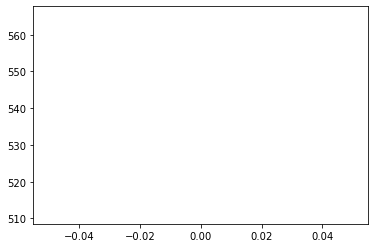

Epoch 2 | Combined Loss 579.9266000490144 | Clustering Loss 576.8708499174073 | LM Loss 3.0557501316070557: 100%|██████████| 54/54 [00:05<00:00,  9.83it/s]  


############################################################
NN Measures
NMI: 0.1699034515765521
Accuracy: ({0: 1, 1: 3, 2: 2, 3: 0}, 0.4205607476635514)
ARI: 0.05540528496794953
tensor([261.1272, 270.9822, 270.9822, 261.1272], device='cuda:0')
tensor([[-0.0554, -0.0145, -0.1386,  ..., -0.0342,  0.1878,  0.4609],
        [-0.1530, -0.0975,  0.1332,  ..., -0.0828,  0.3362,  0.4902],
        [-0.1504, -0.0233, -0.0910,  ..., -0.1499,  0.3769,  0.4145],
        [-0.0527, -0.0487,  0.0077,  ..., -0.0287,  0.3828,  0.3546]],
       device='cuda:0', requires_grad=True)


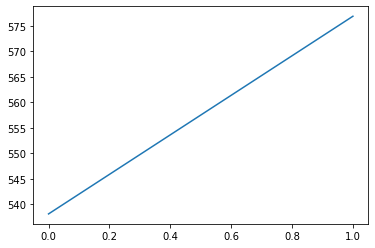

Epoch 3 | Combined Loss 514.0530325259103 | Clustering Loss 511.03242958439733 | LM Loss 3.0206029415130615:   0%|          | 0/54 [00:00<?, ?it/s]

tensor(True)


Epoch 3 | Combined Loss 550.1617733157304 | Clustering Loss 546.8580101645616 | LM Loss 3.3037631511688232: 100%|██████████| 54/54 [00:05<00:00,  9.72it/s]  


############################################################
NN Measures
NMI: 0.14610771592510657
Accuracy: ({0: 1, 1: 3, 2: 2, 3: 0}, 0.397196261682243)
ARI: 0.03270485374640904
tensor([261.1272, 270.9822, 270.9822, 261.1272], device='cuda:0')
tensor([[-0.0554, -0.0145, -0.1386,  ..., -0.0342,  0.1878,  0.4609],
        [-0.1530, -0.0975,  0.1332,  ..., -0.0828,  0.3362,  0.4902],
        [-0.1504, -0.0233, -0.0910,  ..., -0.1499,  0.3769,  0.4145],
        [-0.0527, -0.0487,  0.0077,  ..., -0.0287,  0.3828,  0.3546]],
       device='cuda:0', requires_grad=True)


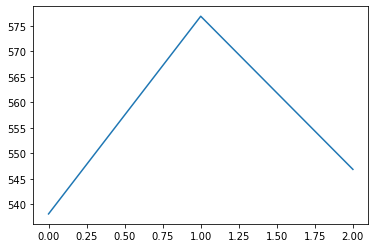

Epoch 4 | Combined Loss 502.6666038545077 | Clustering Loss 499.1855643304293 | LM Loss 3.481039524078369:   0%|          | 0/54 [00:00<?, ?it/s]

tensor(True)


Epoch 4 | Combined Loss 588.6671915255428 | Clustering Loss 585.9315283499599 | LM Loss 2.7356631755828857: 100%|██████████| 54/54 [00:05<00:00,  9.75it/s]  


############################################################
NN Measures
NMI: 0.1632628524110542
Accuracy: ({0: 3, 1: 1, 2: 2, 3: 0}, 0.411214953271028)
ARI: 0.05122176975557998
tensor([261.1272, 270.9822, 270.9822, 261.1272], device='cuda:0')
tensor([[-0.0554, -0.0145, -0.1386,  ..., -0.0342,  0.1878,  0.4609],
        [-0.1530, -0.0975,  0.1332,  ..., -0.0828,  0.3362,  0.4902],
        [-0.1504, -0.0233, -0.0910,  ..., -0.1499,  0.3769,  0.4145],
        [-0.0527, -0.0487,  0.0077,  ..., -0.0287,  0.3828,  0.3546]],
       device='cuda:0', requires_grad=True)


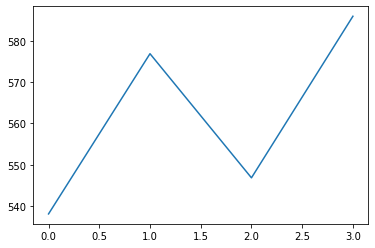

Epoch 5 | Combined Loss 501.03162778266 | Clustering Loss 497.5286582792573 | LM Loss 3.50296950340271:   0%|          | 0/54 [00:00<?, ?it/s]

tensor(True)


Epoch 5 | Combined Loss 511.0574583539233 | Clustering Loss 508.3029429444537 | LM Loss 2.7545154094696045: 100%|██████████| 54/54 [00:05<00:00,  9.70it/s]  


############################################################
NN Measures
NMI: 0.21248724694724638
Accuracy: ({0: 1, 1: 3, 2: 2, 3: 0}, 0.42990654205607476)
ARI: 0.06718113503543276
tensor([261.1272, 270.9822, 270.9822, 261.1272], device='cuda:0')
tensor([[-0.0554, -0.0145, -0.1386,  ..., -0.0342,  0.1878,  0.4609],
        [-0.1530, -0.0975,  0.1332,  ..., -0.0828,  0.3362,  0.4902],
        [-0.1504, -0.0233, -0.0910,  ..., -0.1499,  0.3769,  0.4145],
        [-0.0527, -0.0487,  0.0077,  ..., -0.0287,  0.3828,  0.3546]],
       device='cuda:0', requires_grad=True)


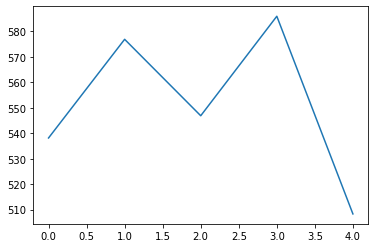

Epoch 6 | Combined Loss 507.20215206781035 | Clustering Loss 504.102687889725 | LM Loss 3.099464178085327:   0%|          | 0/54 [00:00<?, ?it/s]

tensor(True)


Epoch 6 | Combined Loss 550.0985413298159 | Clustering Loss 547.5588513121157 | LM Loss 2.5396900177001953: 100%|██████████| 54/54 [00:05<00:00,  9.72it/s]  


############################################################
NN Measures
NMI: 0.16350062822637254
Accuracy: ({0: 1, 1: 3, 2: 2, 3: 0}, 0.40654205607476634)
ARI: 0.04354891253799978
tensor([261.1272, 270.9822, 270.9822, 261.1272], device='cuda:0')
tensor([[-0.0554, -0.0145, -0.1386,  ..., -0.0342,  0.1878,  0.4609],
        [-0.1530, -0.0975,  0.1332,  ..., -0.0828,  0.3362,  0.4902],
        [-0.1504, -0.0233, -0.0910,  ..., -0.1499,  0.3769,  0.4145],
        [-0.0527, -0.0487,  0.0077,  ..., -0.0287,  0.3828,  0.3546]],
       device='cuda:0', requires_grad=True)


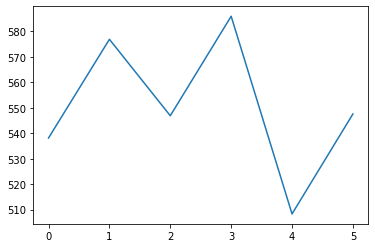

Epoch 7 | Combined Loss 503.9511792533053 | Clustering Loss 501.27582906409634 | LM Loss 2.6753501892089844:   0%|          | 0/54 [00:00<?, ?it/s]

tensor(True)


Epoch 7 | Combined Loss 572.5427447967979 | Clustering Loss 568.1132284813377 | LM Loss 4.429516315460205: 100%|██████████| 54/54 [00:05<00:00,  9.67it/s]   


############################################################
NN Measures
NMI: 0.16725269277274607
Accuracy: ({0: 1, 1: 3, 2: 2, 3: 0}, 0.40654205607476634)
ARI: 0.040077061910933076
tensor([261.1272, 270.9822, 270.9822, 261.1272], device='cuda:0')
tensor([[-0.0554, -0.0145, -0.1386,  ..., -0.0342,  0.1878,  0.4609],
        [-0.1530, -0.0975,  0.1332,  ..., -0.0828,  0.3362,  0.4902],
        [-0.1504, -0.0233, -0.0910,  ..., -0.1499,  0.3769,  0.4145],
        [-0.0527, -0.0487,  0.0077,  ..., -0.0287,  0.3828,  0.3546]],
       device='cuda:0', requires_grad=True)


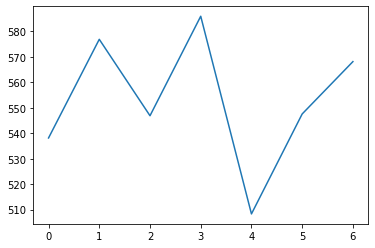

Epoch 8 | Combined Loss 503.0408922017874 | Clustering Loss 499.46898348940033 | LM Loss 3.571908712387085:   0%|          | 0/54 [00:00<?, ?it/s]

tensor(True)


Epoch 8 | Combined Loss 558.9248186068653 | Clustering Loss 556.3152397589802 | LM Loss 2.609578847885132: 100%|██████████| 54/54 [00:05<00:00,  9.61it/s]   


############################################################
NN Measures
NMI: 0.16860458391729635
Accuracy: ({0: 1, 1: 3, 2: 2, 3: 0}, 0.3925233644859813)
ARI: 0.030461534249808336
tensor([261.1272, 270.9822, 270.9822, 261.1272], device='cuda:0')
tensor([[-0.0554, -0.0145, -0.1386,  ..., -0.0342,  0.1878,  0.4609],
        [-0.1530, -0.0975,  0.1332,  ..., -0.0828,  0.3362,  0.4902],
        [-0.1504, -0.0233, -0.0910,  ..., -0.1499,  0.3769,  0.4145],
        [-0.0527, -0.0487,  0.0077,  ..., -0.0287,  0.3828,  0.3546]],
       device='cuda:0', requires_grad=True)


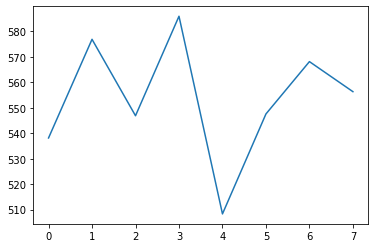

Epoch 9 | Combined Loss 515.5399343158642 | Clustering Loss 512.9366282607953 | LM Loss 2.6033060550689697:   0%|          | 0/54 [00:00<?, ?it/s]

tensor(True)


Epoch 9 | Combined Loss 554.9384874792438 | Clustering Loss 551.7795192690235 | LM Loss 3.158968210220337: 100%|██████████| 54/54 [00:05<00:00,  9.68it/s]   


############################################################
NN Measures
NMI: 0.14244940615322876
Accuracy: ({0: 1, 1: 3, 2: 2, 3: 0}, 0.37850467289719625)
ARI: 0.02149034385014642
tensor([261.1272, 270.9822, 270.9822, 261.1272], device='cuda:0')
tensor([[-0.0554, -0.0145, -0.1386,  ..., -0.0342,  0.1878,  0.4609],
        [-0.1530, -0.0975,  0.1332,  ..., -0.0828,  0.3362,  0.4902],
        [-0.1504, -0.0233, -0.0910,  ..., -0.1499,  0.3769,  0.4145],
        [-0.0527, -0.0487,  0.0077,  ..., -0.0287,  0.3828,  0.3546]],
       device='cuda:0', requires_grad=True)


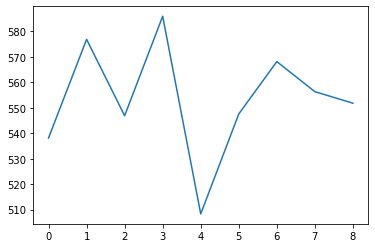

Epoch 10 | Combined Loss 492.98643236304065 | Clustering Loss 489.8359828486516 | LM Loss 3.150449514389038:   0%|          | 0/54 [00:00<?, ?it/s]

tensor(True)


Epoch 10 | Combined Loss 563.3270116449607 | Clustering Loss 559.9735942484153 | LM Loss 3.35341739654541: 100%|██████████| 54/54 [00:05<00:00,  9.55it/s]    


############################################################
NN Measures
NMI: 0.16121059333391413
Accuracy: ({0: 1, 1: 3, 2: 2, 3: 0}, 0.397196261682243)
ARI: 0.039386814420608623
tensor([261.1272, 270.9822, 270.9822, 261.1272], device='cuda:0')
tensor([[-0.0554, -0.0145, -0.1386,  ..., -0.0342,  0.1878,  0.4609],
        [-0.1530, -0.0975,  0.1332,  ..., -0.0828,  0.3362,  0.4902],
        [-0.1504, -0.0233, -0.0910,  ..., -0.1499,  0.3769,  0.4145],
        [-0.0527, -0.0487,  0.0077,  ..., -0.0287,  0.3828,  0.3546]],
       device='cuda:0', requires_grad=True)


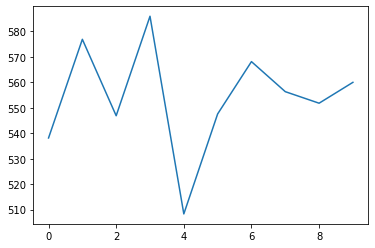

Epoch 11 | Combined Loss 487.59565745019614 | Clustering Loss 484.7163206162423 | LM Loss 2.8793368339538574:   0%|          | 0/54 [00:00<?, ?it/s]

tensor(True)


Epoch 11 | Combined Loss 480.1171864199506 | Clustering Loss 476.74417340038883 | LM Loss 3.3730130195617676:  37%|███▋      | 20/54 [00:02<00:03,  8.81it/s]


KeyboardInterrupt: 

In [28]:
import matplotlib.pyplot as plt

losses = []
old = []
for epoch in range(30):
    new_embeddings, true_labels, predicted_labels, combined_loss = train(
        epoch,
        cluster_model,
        data_loader,
        optimizer=optimizer)
    losses.append(combined_loss)
    plt.plot(losses)
    plt.show()
    old.append(cluster_model.centroids.clone().cpu())
    if epoch > 0:
        print((old[epoch - 1] == old[epoch]).all())
    

In [ ]:
for i in range(4):
    print(torch.abs(cluster_model.centroids[0] - cluster_model.centroids[i]).mean())

In [ ]:
mc = cluster_model.centroids.cpu().detach().numpy()
ic = initial_centroids.cpu().detach().numpy()

ym = np.ones(4)
yi = np.zeros(4)

c = np.concatenate([mc, ic])
y = np.concatenate([ym, yi])

In [ ]:
from umap import UMAP
from sklearn.decomposition import PCA
umap = PCA(n_components=2)
Xo = np.vstack([embeddings, ic])
Xro = umap.fit_transform(Xo)
labels_co = np.concatenate([labels, [f"Centroid {i}" for i in range(4)]])

In [ ]:
sns.scatterplot(x=Xro[:, 0], y=Xro[:, 1], hue=[f'{i}' for i in labels_co])

In [ ]:
import plotly.express as px
fig = px.scatter(x=Xro[:, 0], y=Xro[:, 1], color=[f'{i}' for i in labels_co])
fig.show()

In [ ]:
from umap import UMAP
umap = PCA(n_components=2)
Xn = np.vstack(new_embeddings)
Xn = np.vstack([Xn, mc])
Xrn = umap.fit_transform(Xn)
labels_c = np.concatenate([predicted_labels, [f"Centroid {i}" for i in range(4)]])

In [ ]:
sns.scatterplot(x=Xrn[:, 0], y=Xrn[:, 1], hue=[f'{i}' for i in labels_c])

In [ ]:
import plotly.express as px
fig = px.scatter(x=Xrn[:, 0], y=Xrn[:, 1], color=[f'{i}' for i in labels_c])
fig.show()

In [ ]:
new_embeddings.shape

In [ ]:
np.vstack(new_embeddings).shape

In [ ]:
predicted_labels, true_labels

In [ ]:
d.argmin(dim=1)

In [ ]:
torch.tensor([[440.9798, 450.8352, 440.8814, 459.5430],
        [427.6426, 438.6551, 438.5712, 454.0493],
        [434.4702, 445.4218, 429.3267, 445.5245],
        [442.3625, 443.0142, 440.0734, 452.7371],
        [434.8301, 444.0662, 437.4031, 456.6936],
        [419.6922, 431.4528, 425.4351, 450.7135],
        [450.8062, 462.0776, 455.6161, 456.2221]]).argmin(dim=1)

In [ ]:
a = torch.tensor([[1,2,3]], dtype=torch.float64)
b = torch.tensor([[3,2,1],
                  [3,2,1]], dtype=torch.float64)

In [ ]:
lp_distance(a,b, p=1)

In [ ]:
lp_distance(a,b, p=2)

In [ ]:
from scipy.spatial.distance import euclidean, minkowski
euclidean(a.numpy(), b.numpy()[0]), minkowski(a.numpy(), b.numpy()[0], p=1)

In [ ]:
parameterized_softmax(d, p=100)

In [ ]:
from scipy.special import softmax
softmax(d, axis=1).sum(axis=1)

In [ ]:
1.1463e-16

In [ ]:
def _softmax(X):
    """
    Computes the parameterized softmax of an 2d array along the first axis.
    """
    return torch.exp(X) / torch.sum(torch.exp(X), dim=1).unsqueeze(1)

In [ ]:
_softmax(d), parameterized_softmax(d, p=0.00001).sum(dim=1)

In [ ]:
p = -1
parameterized_softmax(d, p=p), parameterized_softmax(d, p=p).sum(dim=1)

In [ ]:
new_pred = kmeans.fit_predict(np.vstack(new_embeddings))

In [ ]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

print(cluster_accuracy(labels, new_pred)[1])
print(normalized_mutual_info_score(labels, new_pred))
print(adjusted_rand_score(labels, new_pred))

In [ ]:
d.min(dim=1).indices

# debug

In [ ]:
cluster_model.eval()

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
sm = nn.Softmax()
sg = nn.Sigmoid()

In [ ]:
from scipy.signal import savgol_filter
centroids = initial_centroids.clone().to('cuda').requires_grad_(True)
#centroids = torch.Tensor(4, 768).uniform_(-10, 10).to(torch.float64).to('cuda').requires_grad_(True)
#centroids = kmean_centroids.clone().to('cuda').requires_grad_(True)  # go this way (cluster hardening)
opt = torch.optim.SGD(params=[centroids], lr=0.001)

opt.zero_grad()

losses = []
c_hist = []
for epoch in range(3):
    
    predicted_labels = []
    true_labels = []
    embs = []

    cluster_model.eval()
    c_hist.append(centroids.clone().detach().cpu().numpy())
    pbar = tqdm(enumerate(data_loader))
    for batch, batch_data in pbar:
        texts, labels = batch_data
        inputs = tokenizer(
                    texts,
                    return_tensors='pt',
                    padding=True,
                    truncation=True)
        inputs = inputs.to('cuda')
        
        true_labels.extend(labels)
        
        # 0. obtain embeddings for each input
        input_embeddings = cluster_model.embed(inputs)
        input_embeddings = input_embeddings.to(torch.float64)
        
        embs.append(input_embeddings.cpu().detach().numpy())


        distances = torch.stack([lp_distance(embedding.unsqueeze(0), centroids) for embedding in input_embeddings])
        #nearest_centroids = torch.argmin(distances, dim=1).cpu().clone().detach()
        nearest_centroids = torch.argmin(distances.cpu().clone().detach(), dim=1)
        distances = torch.transpose(distances, 0, 1)    

        # => shape (n_centroids, n_samples)
        # 2. compute the softmax for each centroid of each distance to each centroid per input sample
        # find min distances for each centroid
        #nearest_centroids = torch.min(distances, dim=0).indices.cpu().clone().detach()

        min_distances = torch.min(distances, dim=1).values
        exponentials = torch.exp(-1 * (distances - min_distances.unsqueeze(1)))
        softmax = exponentials / torch.sum(exponentials, dim=1).unsqueeze(1)

        # 3. weight the distanace between each sample and each centroid
        weighted_distances = distances * softmax


        # 4. sum over centroids to obtain loss
        #clustering_loss = weighted_distances.mean(dim=1).sum()
        #clustering_loss = weighted_distances.min(dim=1).values.sum()
        
        opt.zero_grad()
        
        clustering_loss = weighted_distances.sum(dim=1).sum()
        clustering_loss.backward()

        #
        #import pdb; pdb.set_trace()
        opt.step()
        
        #with torch.no_grad():
        #    acc_grads = centroids.grad.data.sum()
        #    centroids.sub_(0.0001 * centroids.grad) #0.001
        #centroids.grad = torch.zeros_like(centroids.grad) 

        
        predicted_labels.extend(nearest_centroids.numpy())
        losses.append(clustering_loss.item())
        
        pbar.set_description(f"Epoch {epoch} | Batch: {batch} | Loss: {clustering_loss.item()}")
        
        #print(centroids)
    
    plt.plot(losses)
    plt.plot(savgol_filter(losses, 51, 3), color='red')
    plt.show()

In [ ]:
np_centroids = centroids.cpu().detach().numpy()
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels).astype('int')
true_labels.shape, predicted_labels.shape

embs = np.vstack(embs)

In [ ]:
print(cluster_accuracy(true_labels, predicted_labels))
print(normalized_mutual_info_score(true_labels, predicted_labels))

In [ ]:
np.unique(predicted_labels, return_counts=True)

In [ ]:
np.unique(true_labels, return_counts=True)

In [ ]:
np.unique(kmeans_cluster, return_counts=True)

In [ ]:
from umap import UMAP
from sklearn.decomposition import PCA
umap = UMAP(n_components=2)
Xo = np.vstack([embs, np_centroids])
Xro = umap.fit_transform(Xo)
labels_co = np.concatenate([predicted_labels, [f"Centroid {i}" for i in range(4)]])
label_kmeans = np.concatenate([kmeans_cluster, [f"Centroid {i}" for i in range(4)]])

In [ ]:
import plotly.express as px
fig = px.scatter(x=Xro[:, 0], y=Xro[:, 1], color=[f'{i}' for i in labels_co])
fig.show()

In [ ]:
import plotly.express as px
fig = px.scatter(x=Xro[:, 0], y=Xro[:, 1], color=[f'{i}' for i in label_kmeans])
fig.show()

In [ ]:
(c_hist[0][0] == c_hist[1][0]).all()

In [ ]:
c_hist[1][0]

In [ ]:
np.linalg.norm(c_hist[0][0])

In [ ]:
np.linalg.norm(c_hist[1][0])

In [ ]:
np.linalg.norm(c_hist[2][0])

In [ ]:
centroids.shape